In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as st
from datetime import datetime

In [19]:
model_path = "/home/aevans/convLSTM/src/data/temp_df/20240331/Mohawk Valley/20240331_15:46_ml_output.parquet"

clim_div = 'Mohawk Valley'

full_df_path = '/home/aevans/convLSTM/src/data/temp_df/20240331/Mohawk Valley/Mohawk Valley_CAMD.parquet'

In [20]:
nysm_cats_path = "/home/aevans/nwp_bias/src/landtype/data/nysm.csv"
nysm_cats_df = pd.read_csv(nysm_cats_path)
stations = nysm_cats_df[nysm_cats_df['climate_division_name']==clim_div]['stid'].unique()
stations

array(['CAMD', 'HERK', 'JOHN', 'OPPE', 'SPRA', 'WEST'], dtype=object)

In [21]:
df = pd.read_parquet(model_path)
df = df.sort_index()

In [22]:
df

,0_convLSTM_output,0_target,1_convLSTM_output,1_target,2_convLSTM_output,2_target,3_convLSTM_output,3_target,4_convLSTM_output,4_target,5_convLSTM_output,5_target
0,-0.099421,-0.314755,0.137429,0.027452,-0.368713,-0.534891,0.434207,0.609343,0.142493,-1.384741,0.327965,-1.533985
1,0.524161,-0.647333,0.005548,0.316203,0.212264,-1.099413,0.397218,0.595250,0.385544,-1.958878,0.533756,-1.747250
2,0.109869,-0.167850,-0.423262,0.263237,0.569092,-0.091111,0.329314,-0.140074,-0.008883,-1.297019,-0.411825,-1.788382
3,0.227155,-0.483740,0.620669,0.380887,-0.328198,-0.044857,0.582573,1.576964,0.596771,-0.926346,0.553373,-0.159364
4,-0.182652,2.301675,-0.309542,0.451185,-0.416576,0.074448,0.383639,0.892727,0.421364,0.769951,-0.096758,-0.180089
...,...,...,...,...,...,...,...,...,...,...,...,...
48542,-0.189926,-0.610262,-0.298902,-0.351226,-0.613412,-0.769265,0.332164,0.083325,-0.568914,-0.563675,-0.069207,-0.049682
48543,-0.378972,-1.094895,-0.292091,-1.164314,-0.499021,-0.745370,0.291549,-0.200732,-0.601542,-0.698523,-0.141858,-0.564140
48544,-0.527987,-1.268585,-0.366909,-1.550458,-0.444589,-0.987515,0.036273,-0.678765,-0.671366,-1.117133,0.029048,-0.757786
48545,-0.599103,-1.173881,-0.262681,-1.503778,-0.457911,-0.725308,-0.402139,-0.630712,-0.696014,-1.429067,-0.056906,-0.780501


In [23]:
full_df = pd.read_parquet(full_df_path)

In [24]:
def which_fold(df, fold):
    length = len(df)
    test_len = int(length * 0.2)
    df_train = pd.DataFrame()

    for n in np.arange(0, 5):
        if n != fold:
            df1 = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            df_train = pd.concat([df_train, df1])
        else:
            df_test = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]

    return df_train['valid_time'], df_test['valid_time']

In [25]:
df_train, df_test = which_fold(full_df, 3)

In [26]:
df_test.iloc[0]

Timestamp('2021-07-19 01:00:00')

In [27]:
df_test.iloc[-1]

Timestamp('2022-09-18 12:00:00')

In [28]:
vt = full_df['valid_time'].to_list()
vt = vt[:int(len(df)-len(full_df))]
df['valid_time'] = vt

In [29]:
df = df[df['valid_time'] > datetime(2021, 9, 1, 0, 0, 0)]
df = df[df['valid_time'] < datetime(2021, 10, 30, 23, 0, 0)]
df = df.drop(columns='valid_time')

In [30]:
def plot_outputs(df_out, clim_div, stations):
    import matplotlib.pyplot as plt 
    df_out = df_out.sort_index()
    fig, axs = plt.subplots(int(df_out.shape[1]/2), figsize=(21, 21), sharex=True, sharey=True)
    n = int(df_out.shape[1]/2)
    i = 0
    while n>i:
        axs[i].set_ylabel(f'{stations[i]}')
        axs[i].plot(df_out[f'{i}_target'], c="r", label="Target")
        axs[i].plot(df_out[f"{i}_convLSTM_output"], c="b", alpha=0.7, label="convLSTM Output")
        
        print(f"Mean Absolute Difference of {stations[i]}: {abs(df_out[f'{i}_target'] - df_out[f'{i}_convLSTM_output']).mean()}")
        i+=1
    fig.suptitle(f"convLSTM Output v Target", fontsize=28)
    # axs[-1].set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023], fontsize=18)
    # axs[-1].set_xticks(np.arange(0, len(df_out["0_target"])+1, (len(df_out["0_target"])) / 6))
    axs[0].legend()
    plt.tight_layout()

Mean Absolute Difference of CAMD: 0.714525641500032
Mean Absolute Difference of HERK: 0.6880535888574569
Mean Absolute Difference of JOHN: 0.7443782184485083
Mean Absolute Difference of OPPE: 0.6602454437950206
Mean Absolute Difference of SPRA: 0.6665600296476566
Mean Absolute Difference of WEST: 0.6217139818600537


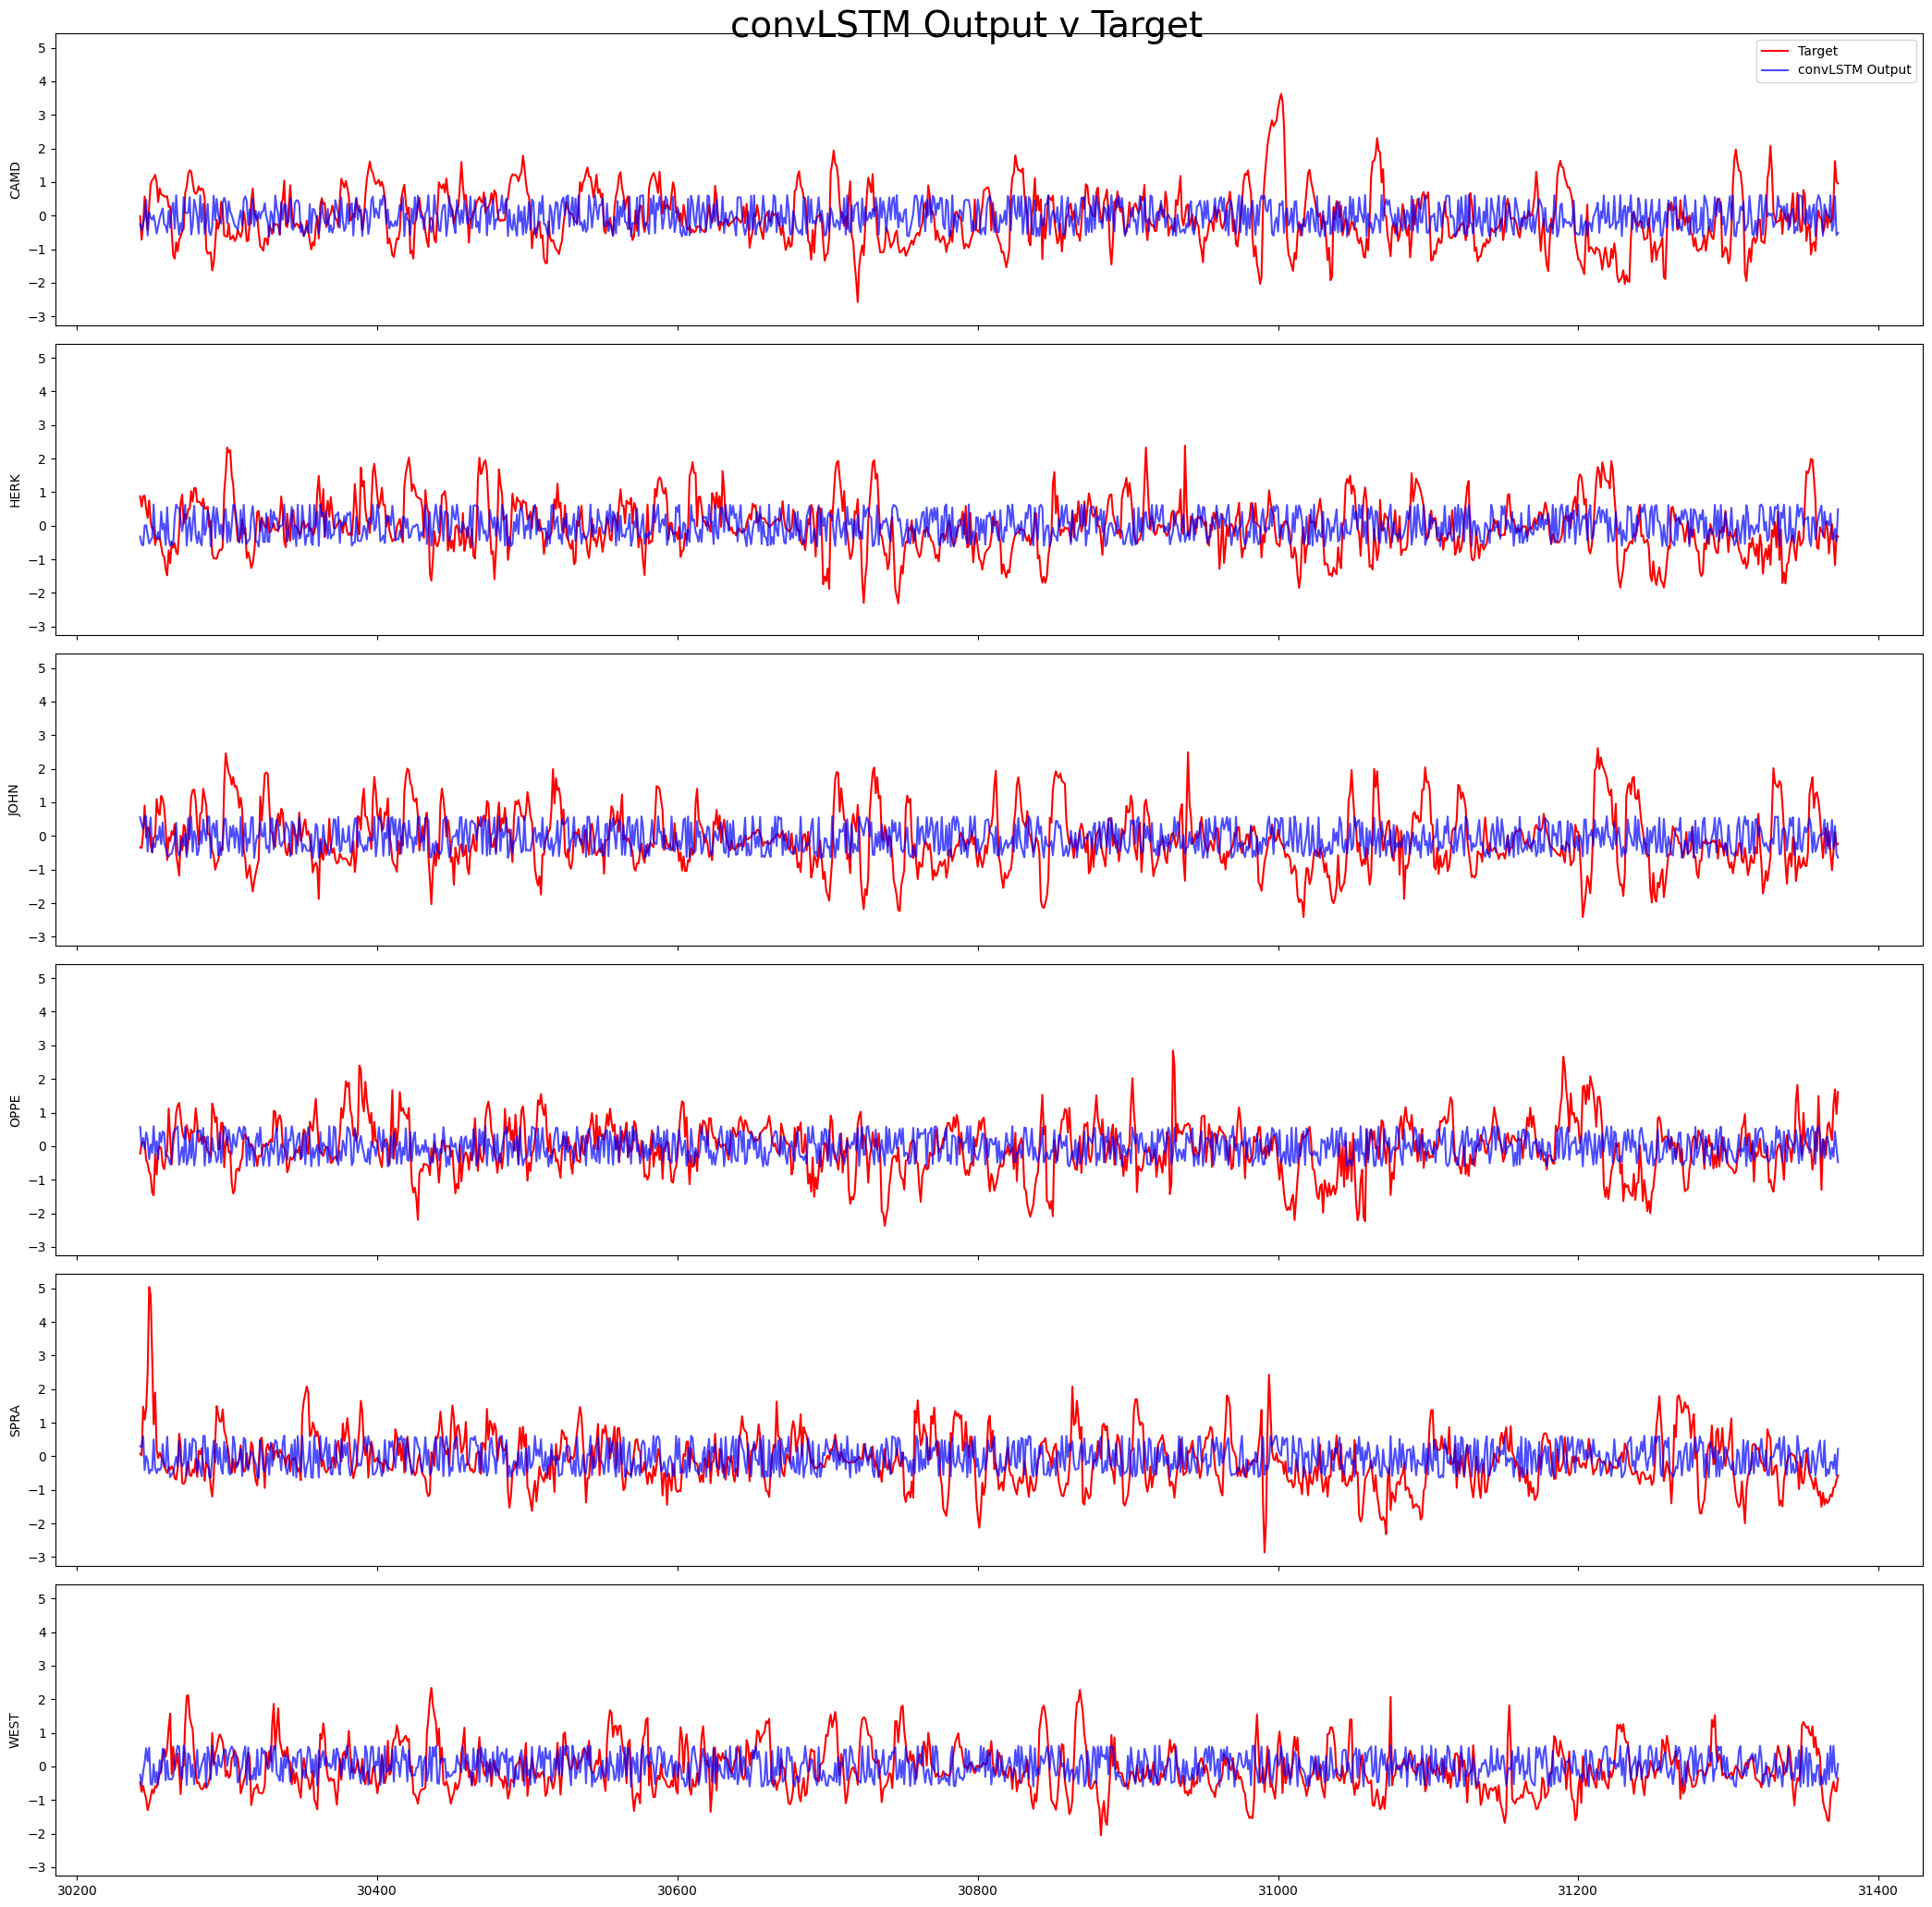

In [31]:
plot_outputs(df, clim_div, stations)